# Simple Moving Average Crossover Strategy

Author: Marcello Chiuminatto

## Strategy Definition

This strategy is one of the simplest trend following FOREX trading strategy.

Is defined as follows:

1. Use three simple moving averages 10 ($SMA_{10})$, 20 ($SMA_{25}$), 50 ($SMA_{50}$).

What is a **Simple Moving Average (SMA)** of $n$ periods?

It is the average of the last $n$ available price periods. Generally is calculated on close price (which is the case for this research), bit can also be calculated on open, high, low, typical price etc.)

Mathematically:

$SMA(close;n)=\frac{1}{n}\sum_{i=t-n+1}^{i=0} close_i$


*Simple moving average as on close parametrized with n (periods)*

Where:

- $n$ Number of periods
- $close_i$: close price at i-th period

2. Long trades rule

 **Entry**<br><br>
  Enter long when close cross above $SMA_{10}$ and $SMA_{10}$ is above $SMA_{25}$ and $SMA_{25}$ is above $SMA_{50}$
  
  Mathematically:
  
  Enter long when the following two conditions are true
  
  1. $close_{t-1}<SMA_{10} \land close_t > SMA_{10}$
  2. $SMA_{50} < SMA_{25} < SMA_{50}$
 
  **Exit**<br><br> 
    Exit a long position when $SMA_{10}$ cross below $SMA_{25}$

    Mathematically

    Exit when

    1. $SMA_{10}<SMA_{25}$


Example



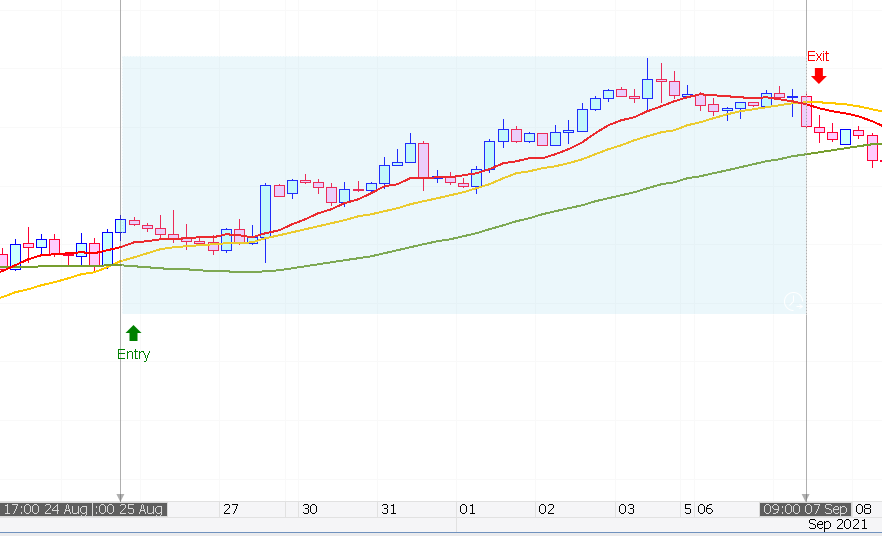

## Strategy Back-testing

## Imports

In [1]:
import pandas as pd
import numpy as np
import talib as ta

import sys

try:
    import mplfinance as mpf
except ImportError:
    %pip install mplfinance
    import mplfinance as mpf
    

try:
    import yfinance as yf
except ImportError:
    %pip install yfinance
    import yfinance as yf
    

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="whitegrid")

## Global Variables

In [2]:
 SMA_fast = 10
SMA_med = 25
SMA_slow = 50

COL_f = f'SMA_{SMA_fast}'
COL_m = f'SMA_{SMA_med}'
COL_s = f'SMA_{SMA_slow}'

PLOT_FROM = 2000
PLOT_TO = 2250

SYMBOL='EURUSD=X'

DIGITS = 4  # digits where the pip change is counted
if 'JPY' in SYMBOL:
    DIGITS=2
    
PIP_FACTOR = 10**DIGITS  # factor to convert from points change to pip change

TRADE_COST = 1  # estimated spread + commission per trade


### Load Data

In [3]:
df = pd.read_csv('EURUSD_Hourly_Bid_2015.01.01_2021.11.24.csv')
df['Time (UTC)'] = pd.to_datetime(df['Time (UTC)']) 
df.set_index('Time (UTC)', inplace=True)
df.head()

,Open,High,Low,Close,Volume
Time (UTC),,,,,
2015-01-01 22:00:00,1.21038,1.21073,1.20999,1.21014,1069.99
2015-01-01 23:00:00,1.21015,1.21020,1.20783,1.20869,4662.40
2015-01-02 00:00:00,1.20871,1.20890,1.20668,1.20674,3886.31
2015-01-02 01:00:00,1.20675,1.20723,1.20519,1.20670,6203.48
2015-01-02 02:00:00,1.20670,1.20687,1.20476,1.20588,4255.56


In [4]:
# Downlaod data from yahoo finance using yfinance library
# Uncomment of you want to try different symbols

# df = yf.download(SYMBOL, 
#                       start='2020-01-01', 
#                       end='2021-12-31', 
#                       interval='1h',
#                       progress=False)
# df.head()

Records  42988


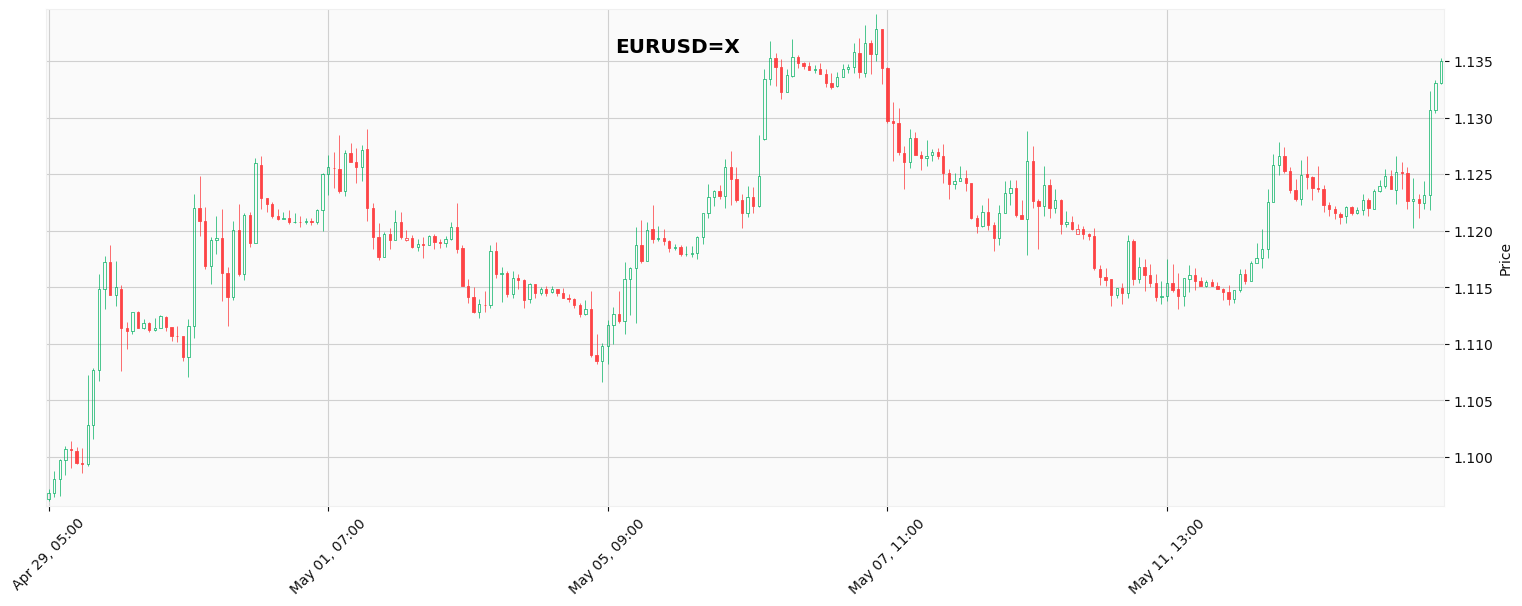

In [5]:
print('Records ', df.shape[0])
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5),
         title=SYMBOL)

## Feature Calculation

Calculate $SMA_10$, $SMA_25$ and $SMA_50$ using pandas rolling windows

In [6]:
df[COL_f] = df['Close'].rolling(SMA_fast).mean()
df[COL_m] = df['Close'].rolling(SMA_med).mean()
df[COL_s] = df['Close'].rolling(SMA_slow).mean()
df.dropna(inplace=True)

In [7]:
ap0 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
       mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green')]

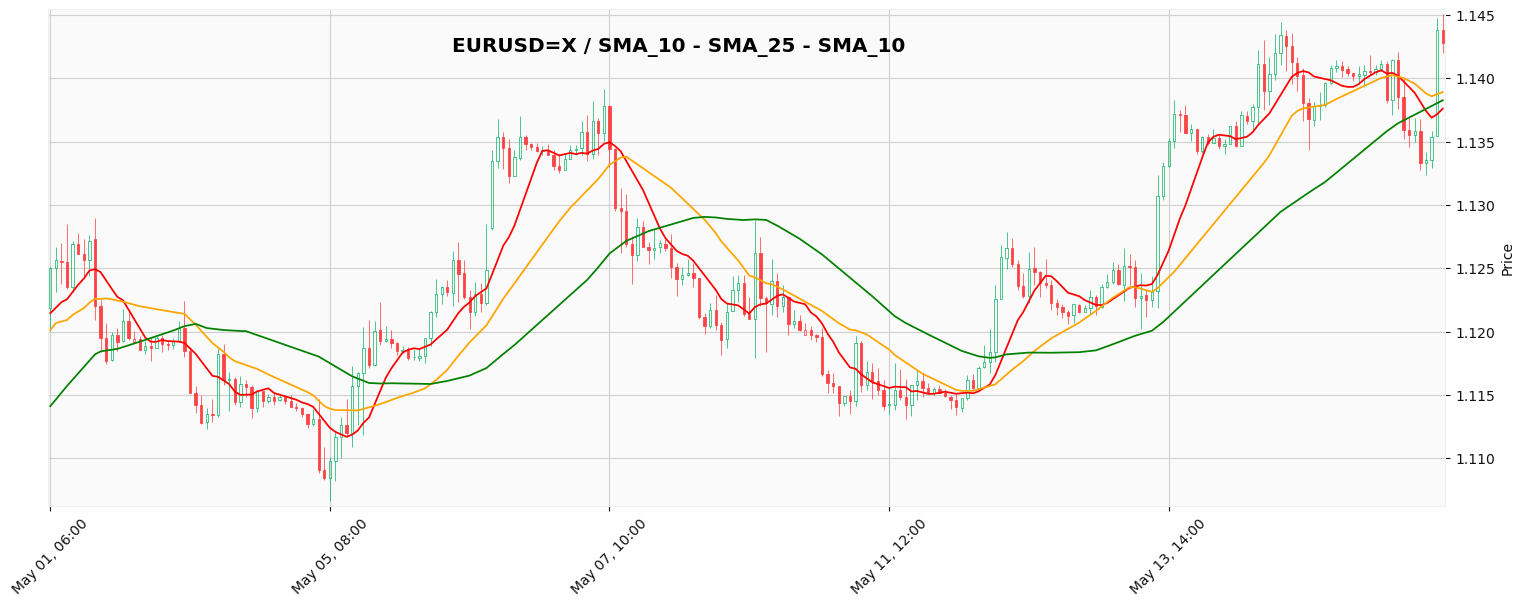

In [8]:
mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap0, title=f'{SYMBOL} / {COL_f} - {COL_m} - {COL_f}')

## Strategy Back-Testing

### Mark Trade Entry/Exit Events

**How to mark entry and exit signals?**

You need to be careful marking entry and exit events. Since a signal is marked once the period or bar is closed, you MUST mark the entry event at the next bar, that will be the entry bar. 

Mathematically then, the entry condition is marked as follows:


Cross over condition:

$CXO_i = \land SMA_{fast, i-1} > SMA_{med, i-1}  \land SMA_{med, i-1} > SMA_{slow, i-1}$


$E_i = close_{i-1} > SMA_{fast, i-1} \land CXO_{i-1}=True \land CXO_{i-2}=False$

$entry_i=\begin{cases}
    1 \text{ if }E_i = True\\
    \emptyset \text{ otherwise}
\end{cases}
$

For exit condition is slightly different:

Cross over exit condition:

$X_i = close_{i} < SMA_{25, i}$

$entry_i = \begin{cases}
    -1 \text{ if }X_i = True \\
    \emptyset \text{ otherwise}
\end{cases}
$

In the example below:

Entry signal is located at $t=4$, because $s_{t-2}=\emptyset \land s_{t-1}=1$. In the other hand, exit signal is located at $t=7$ because $s_{t-1}=1 \land s_t=\emptyset$


| t | entry  | exit |trade |
| - | ------ |------|------|
| 1 |        |      |      |
| 2 |        |      |      |
| 3 | 1      |      |      |
| 4 |        |      |   1  |
| 5 |        |      |   1  |
| 6 |        |      |   1  |
| 7 |        | -1   |   1  |
| 8 |        |      |      |

In [9]:
df['trade'] = np.nan

mask_cxo =   (df[COL_f].shift(1) > df[COL_m].shift(1)) & \
             (df[COL_m].shift(1) > df[COL_s].shift(1))

mask_entry = (mask_cxo.shift(1) == True) & (mask_cxo.shift(2) == False) & (df['Close'] > df[COL_f])

df.loc[mask_entry, 'trade'] = range(1, len(df[mask_entry])+1)

df.loc[(df['trade']>=1), 'plot_entry'] = df[COL_s] - 0.0010

mask_exit = ( df['Close'].shift(1) < df[COL_m].shift(1)) 
df.loc[mask_exit, 'trade'] = -1
df.loc[(df['trade']==-1), 'plot_exit'] = df[COL_s] - 0.0010

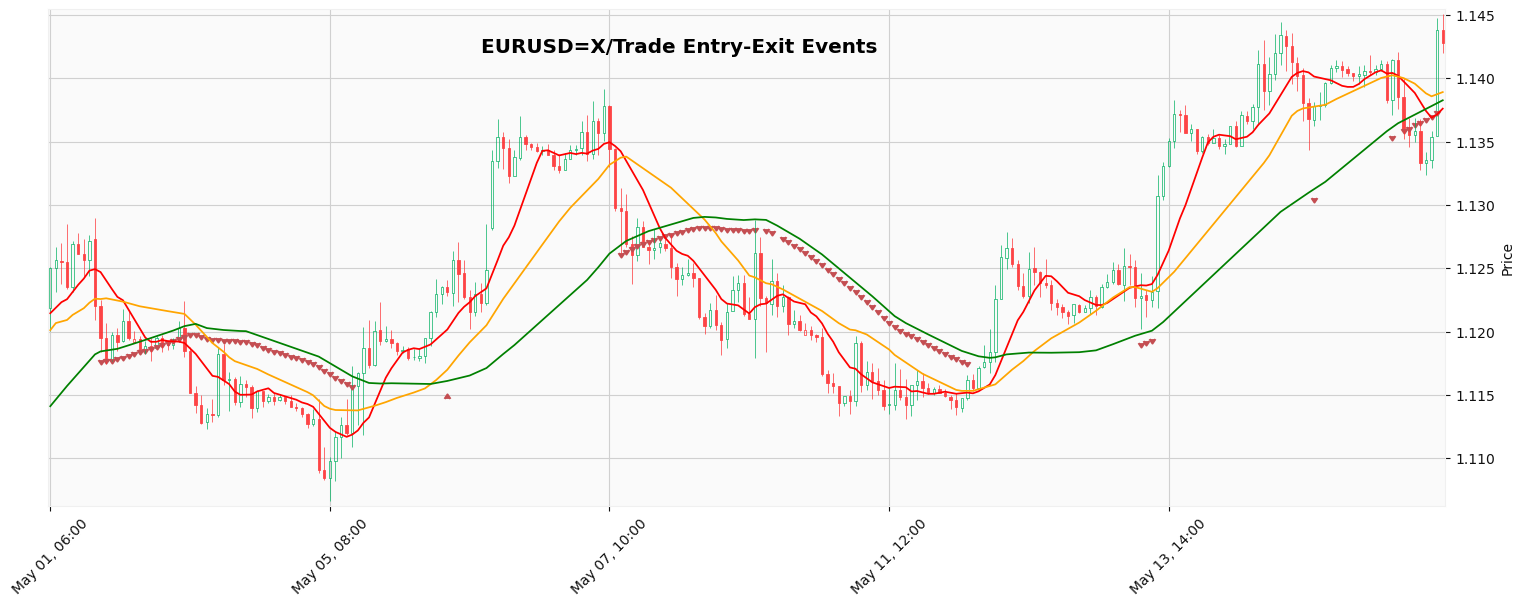

In [10]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_entry'],type='scatter', marker=6, color="r"),
       mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_exit'],type='scatter', marker=7, color="r")
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Events')

### Mark Trades

In [11]:
df['trade'].ffill(inplace=True)
df['trade'] =  df['trade'].replace(-1, np.nan)
mask_trade = df['trade'].isna()
df.loc[~mask_trade, 'plot_trade'] = df.loc[~mask_trade][COL_s] - 0.0005

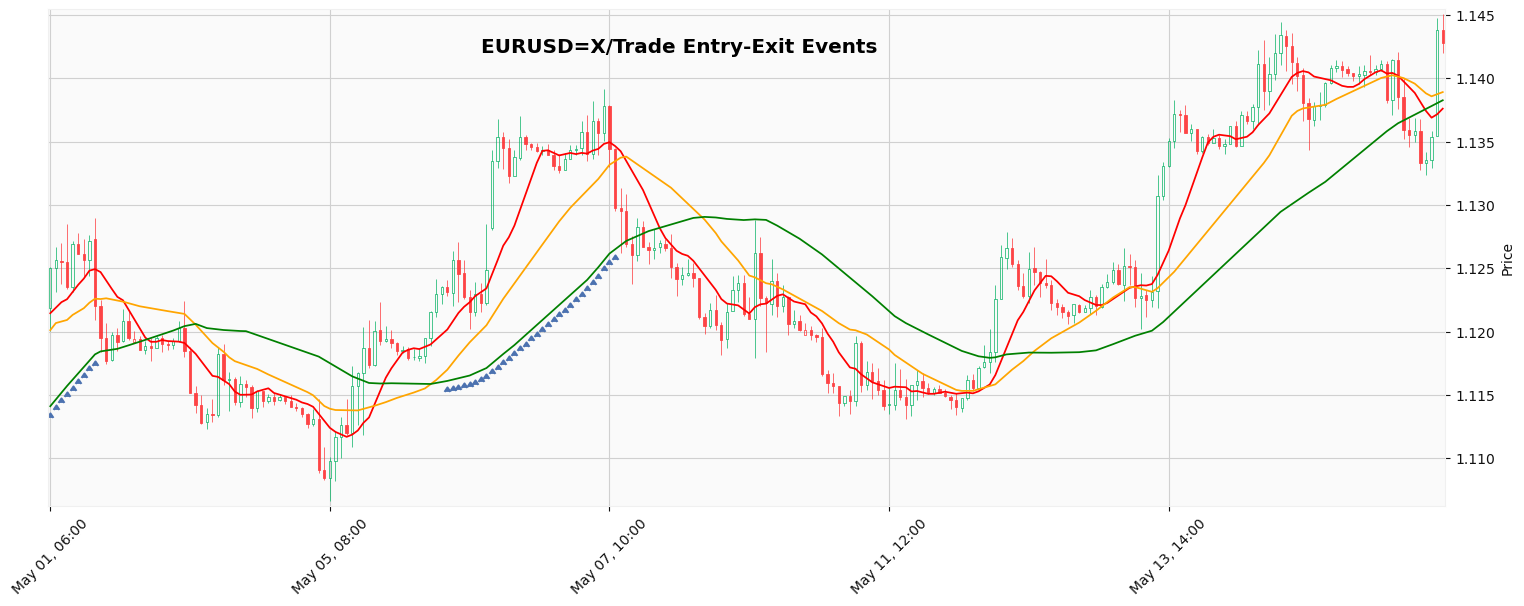

In [12]:
ap4 = [ mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_f],color='red'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_m],color='orange'),  # uses panel 0 by default
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO][COL_s],color='green'),
        mpf.make_addplot(df[PLOT_FROM:PLOT_TO]['plot_trade'],type='scatter', marker=6, color="b")
      ]

mpf.plot(df[PLOT_FROM:PLOT_TO],
         volume=False, 
         type='hollow_and_filled', 
         tight_layout=True, 
         style='yahoo', 
         figratio=(14,5), addplot=ap4, title=f'{SYMBOL}/Trade Entry-Exit Events')

### Calculate Profit [pips]

In [13]:
def profit_report_col(df, column='net_profit'):

        # NON FILTERED
        _mask_tot = df[column] !=0
        _tot_trades = len(df[_mask_tot])

        _mask_win_trades = df[column] > 0
        _tot_win_trades = len(df[_mask_win_trades])
        _tot_win_pft = df[_mask_win_trades][column].sum().round(2)

        _mask_los_trades = df[column] < 0
        _tot_los_trades = len(df[_mask_los_trades])
        _tot_loss_pft = df[_mask_los_trades][column].sum().round(2)

        _total_pft = df[column].sum().round(2)
        _mean_pft = df[column].mean().round(2)
        _std_pft = df[column].std().round(2)
        
        _median_pft = df[column].median().round(2)
        _mode_pft = df[column].mode().round(2)
        
        _skew_pft = df[column].skew().round(2)

        _report = dict()
        _report['column'] = column
        _report['tot_trades'] = _tot_trades
        _report['tot_win_trades'] = _tot_win_trades
        _report['tot_losing_trades'] = _tot_los_trades
        _report['net_profit'] = _total_pft
        _report['win_profit'] = _tot_win_pft
        _report['losing_profit'] = _tot_loss_pft
        _report['avg_profit'] = _mean_pft 
        _report['std_profit'] = _std_pft 
        _report['median_profit'] = _median_pft
        _report['mode_profit'] = _mode_pft[0]
        _report['skew_profit'] = _skew_pft

        return _report

In [14]:
df['date'] = df.index
mask_trade = df['trade']>0
df.loc[mask_trade, 'gross_profit'] = (df.loc[mask_trade, 'Close'] - df.loc[mask_trade, 'Open'] )*PIP_FACTOR
df_trades_pft = df[['trade', 'gross_profit']].groupby(by='trade').sum()
df_trades_date = df[['trade', 'date']].groupby(by='trade').min()

In [15]:
df_trades = pd.merge(df_trades_pft, df_trades_date, how='inner', left_index=True, right_index=True)
df_trades.set_index('date', inplace=True)

In [16]:
df_trades.head(5)

,gross_profit
date,
2015-01-11 23:00:00,-52.0
2015-01-13 03:00:00,-17.6
2015-01-22 01:00:00,-14.0
2015-01-27 11:00:00,55.1
2015-02-02 21:00:00,-4.7


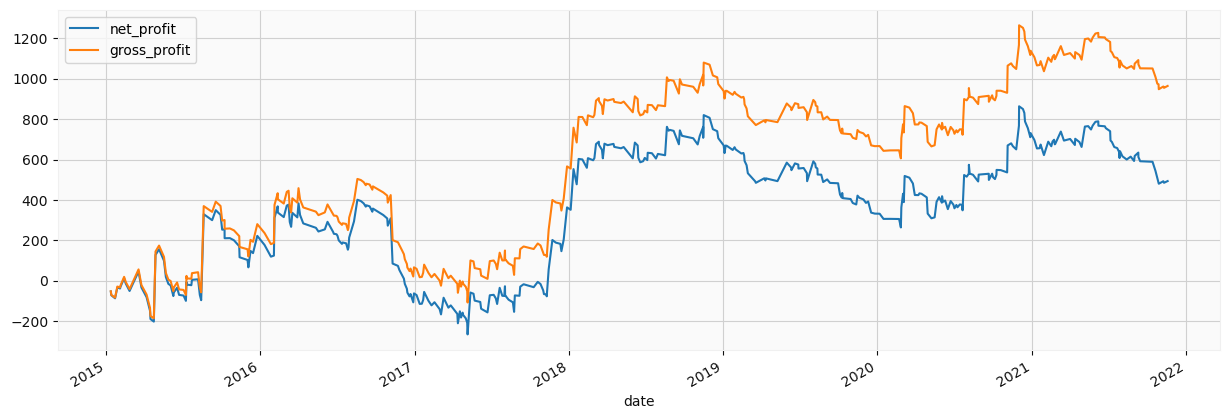

In [17]:
df_trades['net_profit'] = df_trades['gross_profit'] - TRADE_COST
df_trades[['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

In [18]:
report = profit_report_col(df_trades)
for k  in report:
    print(k, '\t  :', report[k])

column 	  : net_profit
tot_trades 	  : 471
tot_win_trades 	  : 156
tot_losing_trades 	  : 315
net_profit 	  : 493.7
win_profit 	  : 6830.4
losing_profit 	  : -6336.7
avg_profit 	  : 1.05
std_profit 	  : 46.82
median_profit 	  : -8.4
mode_profit 	  : -10.9
skew_profit 	  : 3.14


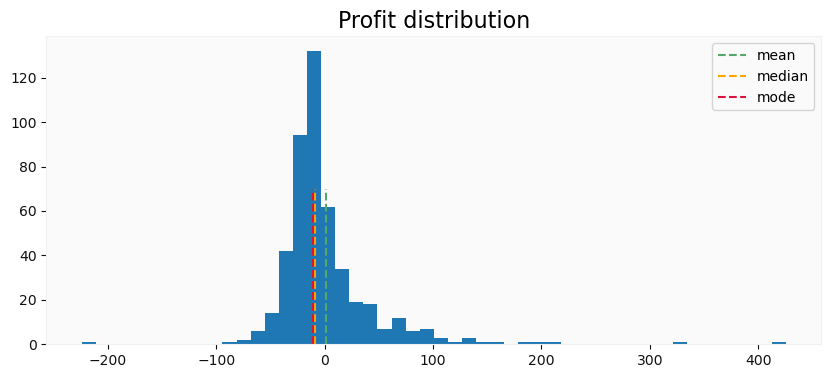

In [19]:
mean_x = report['avg_profit']
median_x = report['median_profit']
mode_x = report['mode_profit']

fig, axis=plt.subplots(1,1, figsize=(10,4))
df_trades['net_profit'].hist(grid=False, bins=50)
plt.plot([mean_x, mean_x], [0, 70], color='g', linestyle='--', label='mean')
plt.plot([median_x, median_x], [0, 70], color='orange', linestyle='--', label='median')
plt.plot([mode_x, mode_x], [0, 70], color='crimson', linestyle='--', label='mode')
plt.legend()
plt.title('Profit distribution', size=16)
plt.show()

**Observations**

Even though the strategy is profitable for the time range back-tested, it is not consistent.

Mainly relies on outliers, which pull the mean (expected profit) to the positive side, but the mode and the median are negative, showing that the bulk of the trades are in the negative side. A good strategy would have the three statistics in the positive side.

All this is confirmed by skewness which is positive indicating a right tailed distribution, which is not good considering mean and mode below zero.

To see the difference between a good strategy and a bad one, 50% of the losing trades will be removed from this strategy result, recalculating then the statistics.

In [20]:
mask=df_trades['net_profit'] < 0
N = int(len(df_trades[mask])/2)
df_losing = df_trades[mask].sample(n=N)
df_trades2 = df_trades.drop(index=df_losing.index)

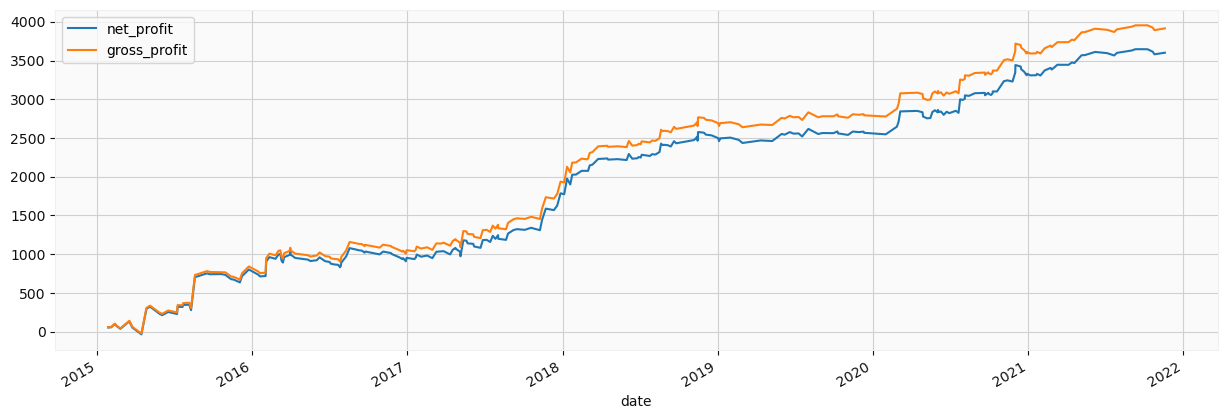

In [21]:
df_trades2['net_profit'] = df_trades['gross_profit'] - TRADE_COST
df_trades2[['net_profit', 'gross_profit']].cumsum().plot(figsize=(15,5))
plt.show()

In [22]:
report = profit_report_col(df_trades2)
for k  in report:
    print(k, '\t  :', report[k])

column 	  : net_profit
tot_trades 	  : 314
tot_win_trades 	  : 156
tot_losing_trades 	  : 158
net_profit 	  : 3600.9
win_profit 	  : 6830.4
losing_profit 	  : -3229.5
avg_profit 	  : 11.47
std_profit 	  : 52.27
median_profit 	  : -0.8
mode_profit 	  : -19.9
skew_profit 	  : 3.12


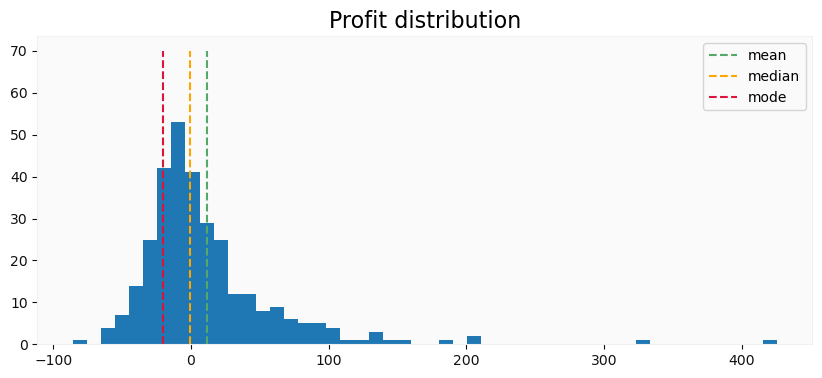

In [23]:
mean_x = report['avg_profit']
median_x = report['median_profit']
mode_x = report['mode_profit']

fig, axis=plt.subplots(1,1, figsize=(10,4))
df_trades2['net_profit'].hist(grid=False, bins=50)
plt.plot([mean_x, mean_x], [0, 70], color='g', linestyle='--', label='mean')
plt.plot([median_x, median_x], [0, 70], color='orange', linestyle='--', label='median')
plt.plot([mode_x, mode_x], [0, 70], color='crimson', linestyle='--', label='mode')
plt.legend()
plt.title('Profit distribution', size=16)
plt.show()